<a href="https://colab.research.google.com/github/Kambey-san/FDMLM/blob/Lesson_03/FDMLM_KAA_HW_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование и диагностика в медицине с помощью машинного обучения
## Урок 3. Установка и импорт пакетов\ ДЗ

Датасет: https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis


заполнить пропуски наиболее релеватным путем, аргументировать это

Таргетом оставляем признак - болен аппендицитом или нет.

Построить три различные типа классификаторов, обязательно одну из них Keras или PyTorch. Построить графики функции потерь на трейне и тесте.

Визуализировать важность признаков с точки зрения модели - чемпиона.

Составить грамотный обобщающий вывод.


In [11]:
!pip install fancyimpute -q
!pip install catboost -q
!pip install shap -q
!pip install eli5 -q
!pip install ucimlrepo -q

In [12]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, IterativeImputer
import missingno as msno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
                        recall_score, f1_score, log_loss, confusion_matrix, \
                  classification_report, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, \
                       LabelEncoder, label_binarize

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
def get_metrics(y_test, y_pred, y_score, name):
    """метрики для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [15]:
# загрузка данных
from ucimlrepo import fetch_ucirepo
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# data (as pandas dataframes)
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

In [16]:
y = y['Diagnosis']

In [17]:
y.isna().sum()

2

In [18]:
df = pd.concat([X, y], axis=1)
df_original = df.copy()

In [19]:
# создание DataFrame для хранения объектов с пропущенными значениями
missing_df = df[df['Diagnosis'].isna()]

# удаление объектов с пропущенными значениями из исходного DataFrame
df = df.dropna(subset=['Diagnosis'])

# проверка количества объектов в исходном и новом DataFrame
print('Количество объектов в исходном DataFrame:', len(df))
print('Количество объектов в новом DataFrame:', len(missing_df))
df_original = df.copy()

Количество объектов в исходном DataFrame: 780
Количество объектов в новом DataFrame: 2


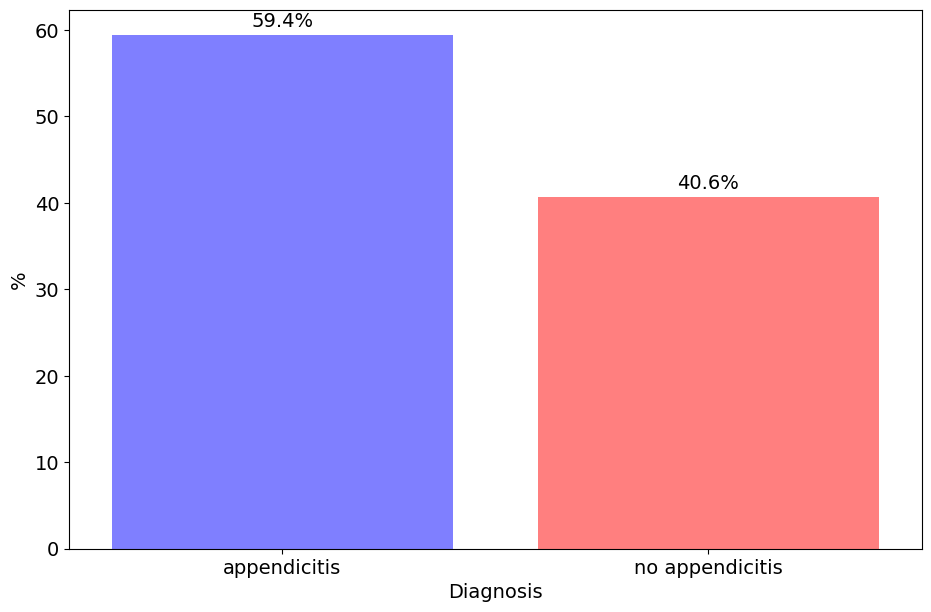

In [23]:
# целевая переменная
norm_target = df['Diagnosis'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
norm_target.columns = ['Diagnosis', 'percent']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x='Diagnosis', y='percent', data=norm_target, alpha=0.5)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14)

colors = ['b', 'r']
for i, p in enumerate(ax.patches):
    p.set_facecolor(colors[i % len(colors)])

plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('%', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Вывод:** применима задача классификации, дисбаланс классов не выражен

### Анализ признаков

In [24]:
df.sample(10)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Diagnosis
448,17.45,17.180000,male,174.0,52.0,2.0,2.0,2.0,yes,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no appendicitis
602,12.46,19.290000,male,161.0,50.0,5.0,9.0,8.0,yes,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,appendicitis
187,9.04,16.200000,female,134.0,29.4,3.0,5.0,5.0,yes,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no appendicitis
506,6.25,14.863258,female,116.0,20.0,8.0,8.0,8.0,yes,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,appendicitis
775,7.88,18.700000,male,130.0,31.6,7.0,7.0,6.0,yes,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,appendicitis
685,13.02,18.420000,male,145.5,39.0,4.0,2.0,2.0,yes,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,appendicitis
507,10.32,14.660000,female,130.6,25.0,6.0,5.0,3.0,yes,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,appendicitis
524,7.42,NaN,female,NaN,25.0,5.0,8.0,6.0,no,NaN,...,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,appendicitis
232,14.29,18.320000,female,167.5,51.4,3.0,6.0,4.0,yes,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,appendicitis
59,17.79,18.400000,male,173.0,55.0,2.0,5.0,6.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,no appendicitis


In [25]:
df.shape

(780, 54)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 0 to 781
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               754 non-null    float64
 2   Sex                               779 non-null    object 
 3   Height                            755 non-null    float64
 4   Weight                            778 non-null    float64
 5   Length_of_Stay                    777 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contralateral

In [30]:
# пропуски
X.isna().any().any()

True

In [31]:
# дубли
X.duplicated().any()

False

In [32]:
target_cols = ['Diagnosis']

# определение категориальных признаков
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop(['Diagnosis'])

# определение числовых признаков
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print('Категориальные признаки:', len(categorical_cols))
print('Числовые признаки:', len(numerical_cols))

Категориальные признаки: 36
Числовые признаки: 17


In [33]:
categorical_cols

Index(['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine',
       'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign',
       'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids',
       'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion',
       'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus',
       'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings'],
      dtype='object')

In [34]:
numerical_cols

Index(['Age', 'BMI', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score', 'Appendix_Diameter',
       'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage',
       'Segmented_Neutrophils', 'RBC_Count', 'Hemoglobin', 'RDW',
       'Thrombocyte_Count', 'CRP'],
      dtype='object')

In [35]:
null = (df.isna().sum() / len(df)) * 100
null = pd.DataFrame({'feature':null.index, 'null_percentage':null}) \
                    .sort_values(by='null_percentage', ascending=False) \
                    .reset_index(drop=True)
null.head(30)

,feature,null_percentage
0,Abscess_Location,98.333333
1,Gynecological_Findings,96.666667
2,Conglomerate_of_Bowel_Loops,94.487179
3,Segmented_Neutrophils,93.076923
4,Ileus,92.307692
5,Perfusion,91.923077
6,Enteritis,91.538462
7,Appendicolith,91.153846
8,Coprostasis,90.897436
9,Perforation,89.615385


In [36]:
# удаление признаков с большим количеством пропусков (> 90%)
df_cols = df.columns
drop_cols = []
for col in df_cols:
    if ((df[col].isna().sum()/len(df) )*100) > 90:
      drop_cols.append(col)
drop_cols

['Segmented_Neutrophils',
 'Appendicolith',
 'Perfusion',
 'Abscess_Location',
 'Conglomerate_of_Bowel_Loops',
 'Ileus',
 'Coprostasis',
 'Enteritis',
 'Gynecological_Findings']

In [37]:
df = df.drop(drop_cols, axis = 1)
df.shape

(780, 45)

In [38]:
# многовариантное восстановление признаков IterativeImputer
# категориальные и числовые колонки
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop(['Diagnosis'])
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# преобразование категориальных признаков в числовые с помощью one-hot encoding
df_cat = pd.get_dummies(df[categorical_cols])
df_num = df[numerical_cols]
df_impute = pd.concat([df_cat, df_num], axis=1)

df_imputed = IterativeImputer(verbose=True).fit_transform(df_impute)

df_imputed = pd.DataFrame(df_imputed, columns=df_impute.columns)
df_imputed.isna().any().any()

[IterativeImputer] Completing matrix with shape (780, 110)
[IterativeImputer] Change: 179.1180474181097, scaled tolerance: 0.708 
[IterativeImputer] Change: 18.67669854307034, scaled tolerance: 0.708 
[IterativeImputer] Change: 8.868748208099788, scaled tolerance: 0.708 
[IterativeImputer] Change: 5.8926508800990405, scaled tolerance: 0.708 
[IterativeImputer] Change: 3.916265647700147, scaled tolerance: 0.708 
[IterativeImputer] Change: 2.9831342633027065, scaled tolerance: 0.708 
[IterativeImputer] Change: 2.671039784053705, scaled tolerance: 0.708 
[IterativeImputer] Change: 2.404313910148862, scaled tolerance: 0.708 
[IterativeImputer] Change: 2.174160398745138, scaled tolerance: 0.708 
[IterativeImputer] Change: 1.973691208756983, scaled tolerance: 0.708 


False

In [39]:
df_imputed = pd.DataFrame(df_imputed, columns=df_impute.columns)
df_imputed.isna().any().any()

False

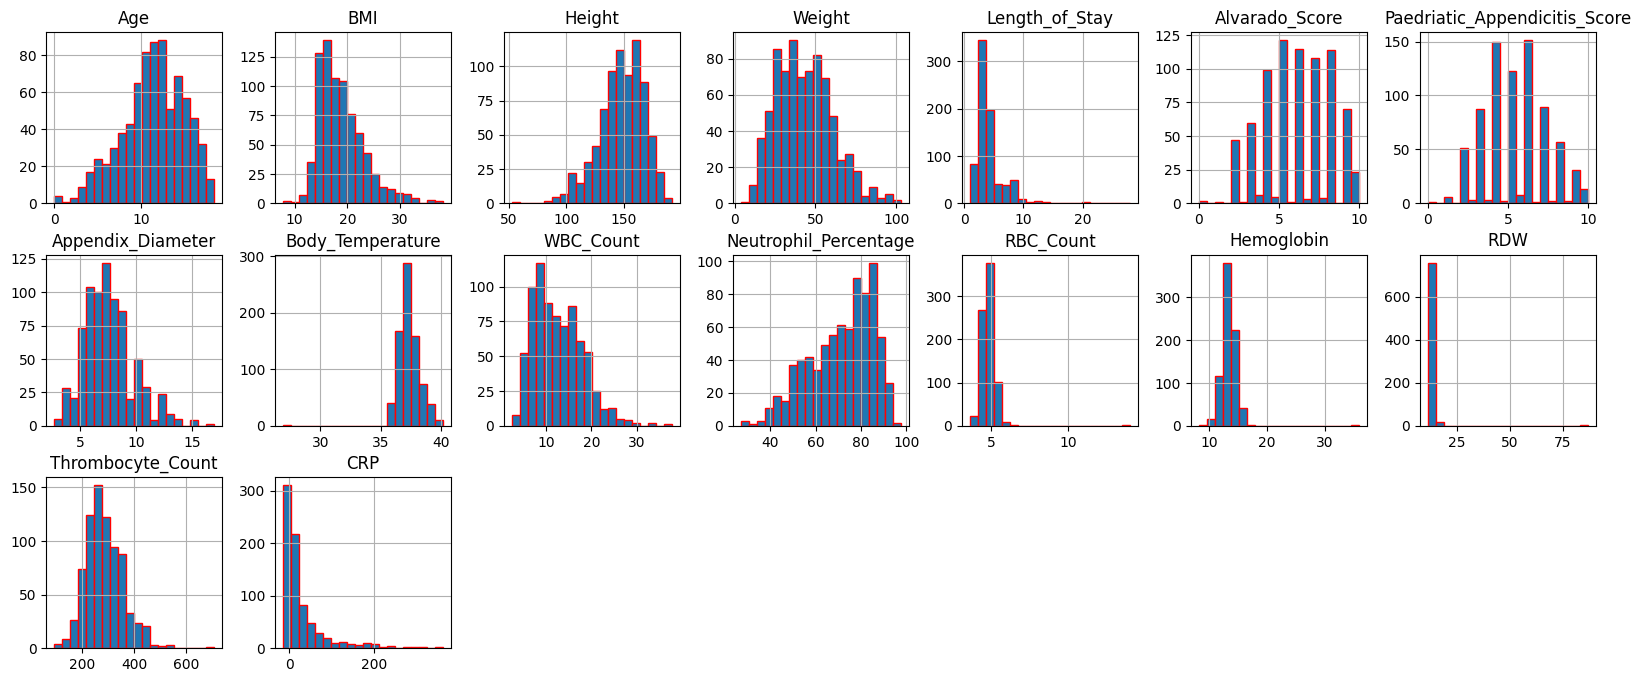

In [40]:
# Распределения признаков
df_imputed[numerical_cols].hist(figsize=(20,8), layout=(-1,7), bins=20, edgecolor='r');

In [41]:
df_imputed.describe()

,Sex_female,Sex_male,Appendix_on_US_no,Appendix_on_US_yes,Migratory_Pain_no,Migratory_Pain_yes,Lower_Right_Abd_Pain_no,Lower_Right_Abd_Pain_yes,Contralateral_Rebound_Tenderness_no,Contralateral_Rebound_Tenderness_yes,...,Paedriatic_Appendicitis_Score,Appendix_Diameter,Body_Temperature,WBC_Count,Neutrophil_Percentage,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,...,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,0.482051,0.516667,0.350000,0.646154,0.720513,0.270513,0.052564,0.939744,0.601282,0.382051,...,5.255212,7.559260,37.401966,12.678553,71.496957,4.798379,13.377995,13.187177,285.471991,31.854917
std,0.499998,0.500043,0.477276,0.478469,0.449035,0.444510,0.223305,0.238114,0.489949,0.486201,...,1.944528,2.178963,0.901517,5.355516,13.931130,0.494387,1.380628,4.472294,71.911277,57.606902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.700000,26.900000,2.600000,27.200000,3.620000,8.200000,11.200000,91.000000,-15.181448
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,4.000000,6.000000,36.800000,8.275000,61.500000,4.540000,12.672454,12.300000,236.000000,1.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,5.000000,7.125598,37.200000,12.000000,74.300000,4.780000,13.300000,12.800000,277.000000,7.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,6.466136,9.000000,37.900000,16.200000,83.095794,5.010000,14.000000,13.300000,330.000000,34.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.000000,17.000000,40.200000,37.700000,97.700000,14.000000,36.000000,86.900000,708.000000,365.000000


<Axes: >

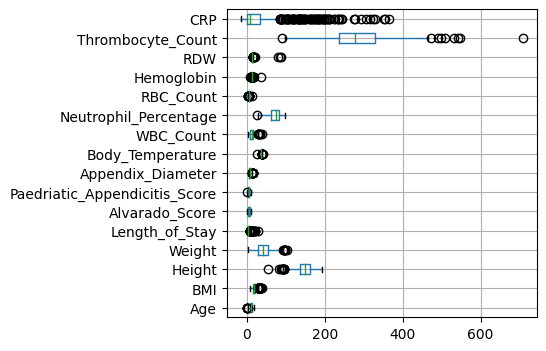

In [42]:
# выбросы
df_imputed[numerical_cols].boxplot(vert=False, figsize=(4, 4))

**Вывод:** необходима нормализация признаков

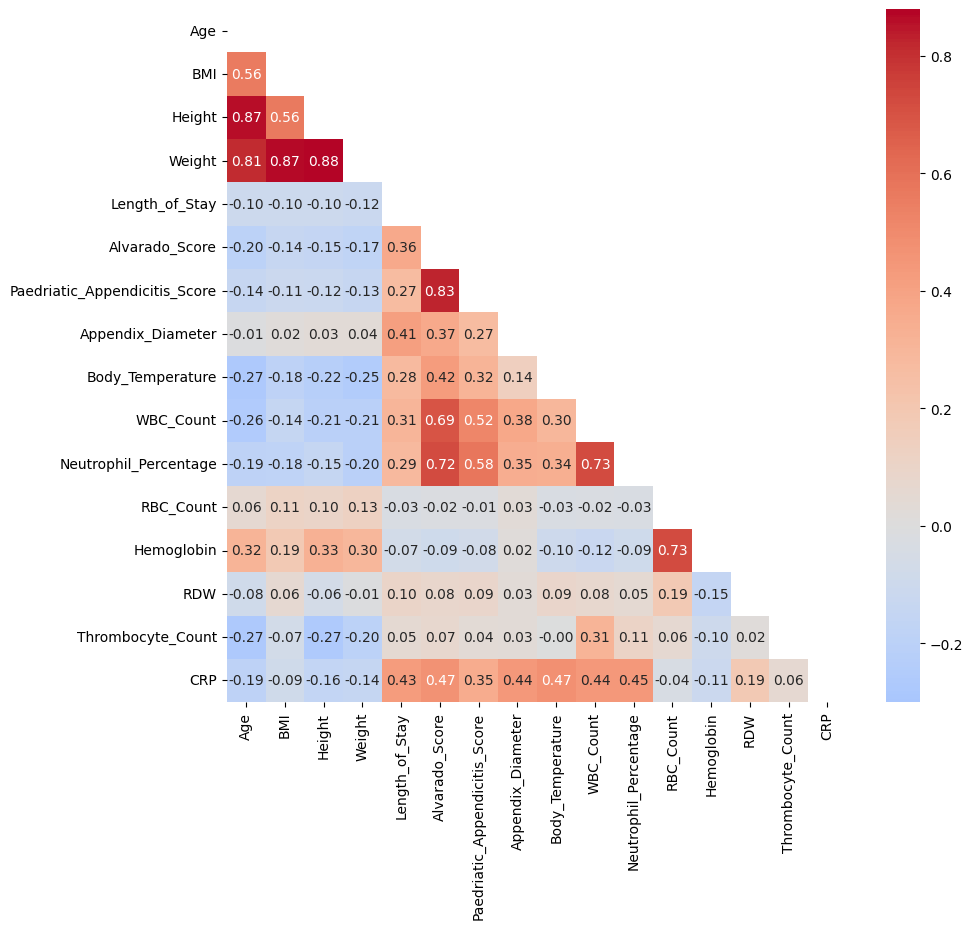

In [43]:
# Матрица корреляции
matrix = np.triu(df[numerical_cols].corr(method='spearman'))

plt.figure(figsize=(10, 9))

sns.heatmap(df[numerical_cols].corr(method='spearman'), annot=True,
            fmt='.2f', vmin=-0.3, center=0, cmap='coolwarm', mask=matrix);

In [44]:
df_imputed.drop(['Height', 'BMI'], inplace=True, axis=1)

## Models

In [45]:
y = df['Diagnosis']
X = df_imputed.copy()

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    )

In [46]:
# кодировка целевой переменной
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

In [47]:
# бинаризация признаков для ROC_AUC
n_classes = len(set(y))
classes_in_test = np.unique(y_test_num)
y_test_bin = label_binarize(y_test_num, classes=[0, 1])

In [48]:
# Catboost
pipe_catboost = Pipeline([('scaler', StandardScaler()),
                         ('clf', CatBoostClassifier(verbose=False))])

pipe_catboost.fit(X_train, y_train_num)

y_pred = pipe_catboost.predict(X_test)
y_score = pipe_catboost.predict_proba(X_test)
print(classification_report(y_test_num, y_pred, target_names=le.classes_))

                 precision    recall  f1-score   support

   appendicitis       0.95      0.96      0.96        85
no appendicitis       0.96      0.94      0.95        71

       accuracy                           0.96       156
      macro avg       0.96      0.95      0.95       156
   weighted avg       0.96      0.96      0.96       156



In [49]:
metrics = get_metrics(y_test_num, y_pred, y_score, name='Catboost_Baseline')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Catboost_Baseline,0.955128,0.981607,0.957143,0.943662,0.950355,0.151606


In [50]:
importance = pipe_catboost.named_steps['clf'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.head(20)

,Feature,Importance
99,Appendix_Diameter,28.172359
2,Appendix_on_US_no,16.451729
3,Appendix_on_US_yes,11.613430
96,Length_of_Stay,10.658120
97,Alvarado_Score,4.754441
41,Ipsilateral_Rebound_Tenderness_no,4.526640
98,Paedriatic_Appendicitis_Score,2.899021
101,WBC_Count,2.300403
38,Peritonitis_no,2.200065
107,CRP,1.445259


**Выводы:** наиболее важные признаки - Appendix_Diameter, Appendix_on_US_no, Appendix_on_US_yes, Length_of_Sta.

Модель отработала хорошо

In [51]:
# Логистическая регрессия
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_train, y_train_num)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test_num, y_pred, target_names=le.classes_))

                 precision    recall  f1-score   support

   appendicitis       0.93      0.91      0.92        85
no appendicitis       0.89      0.92      0.90        71

       accuracy                           0.91       156
      macro avg       0.91      0.91      0.91       156
   weighted avg       0.91      0.91      0.91       156



In [52]:
coef = pipe_lr_base.named_steps['clf'].coef_[0]
feature_names = X.columns
importance = np.abs(coef)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)


print(importance_df.head(20))

                                Feature  Importance
99                    Appendix_Diameter    3.396487
41    Ipsilateral_Rebound_Tenderness_no    1.718508
2                     Appendix_on_US_no    1.303945
96                       Length_of_Stay    1.130183
3                    Appendix_on_US_yes    1.084929
42   Ipsilateral_Rebound_Tenderness_yes    0.863906
40                       Psoas_Sign_yes    0.662126
101                           WBC_Count    0.638739
94                                  Age    0.625227
16                      Neutrophilia_no    0.615742
97                       Alvarado_Score    0.574059
10                     Coughing_Pain_no    0.557272
58      Surrounding_Tissue_Reaction_yes    0.536542
56                      Perforation_yes    0.534360
95                               Weight    0.522438
66              Lymph_Nodes_Location_MB    0.521180
30                           Dysuria_no    0.513635
81           Lymph_Nodes_Location_re UB    0.512979
39          

In [70]:
from eli5 import show_weights

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py)

Веса посмотреть не получается. Не знаю, как пофиксить эту хрень

**Выводы:** логистическая регрессия показала результаты хуже, чем Catboost важным признаком здесь являлись Appendix_Diameter.

In [71]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test_num, y_pred, y_score, name='Log_Reg_Baseline')])

In [72]:
y = df_original['Diagnosis']
X = df_original.copy()
X = X.drop('Diagnosis', axis=1)

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

In [73]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy="median")),
                                      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
                transformers=[("num", numeric_transformer, numerical_cols),
                              ("cat", categorical_transformer, categorical_cols)])


pipe_lr_base = Pipeline([('feature_preprocessor', preprocessor),
                         ('clf', LogisticRegression(max_iter=10))])

pipe_lr_base.fit(X_train, y_train)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   appendicitis       0.90      0.90      0.90        83
no appendicitis       0.89      0.89      0.89        73

       accuracy                           0.90       156
      macro avg       0.90      0.90      0.90       156
   weighted avg       0.90      0.90      0.90       156



**Вывод:** принципиальных различий в результах нет.

In [74]:
# PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import copy

In [75]:
RND_STATE = 1234

In [76]:
def seed_everything(seed=42):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=RND_STATE)

In [77]:
y = df['Diagnosis']
X = df_imputed.copy()

In [78]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Разделение обучающей выборки на обучающую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Кодирование целевой переменной
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_val_num = le.fit_transform(y_val)
y_test_num = le.transform(y_test)

In [79]:
# Создание тензорных наборов данных
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_num, dtype=torch.long)
)

val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val_num, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_num, dtype=torch.long)
)

In [80]:
# Конфигурационный класс
class CFG:
    hidden_size = 128
    dropout = 0.1
    lr = 1e-3
    batch_size = 128
    num_workers = 4
    epochs = 20
    num_features = X_train.shape[1]
    num_tar_class = len(np.unique(y))

In [81]:
# DataLoader
dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers),
    'val': DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers),
    'test': DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
}

In [82]:
# Модель
class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(cfg.num_features, cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )

    def forward(self, data):
        x = self.mlp(data)
        tar_class = self.classifier(x)
        return tar_class

In [83]:
# Функция обучения
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, early_stopping_rounds=5, verbose=2):
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    early_steps = 0
    stop = False

    for epoch in range(num_epochs):
        if stop:
            break
        if epoch % verbose == 0:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if epoch % verbose == 0:
                print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
                early_steps = 0
            if phase == 'val' and epoch_loss > best_loss:
                early_steps += 1
                if early_steps > early_stopping_rounds:
                    stop = True
                    print(f'Stopped by early_stopping. Epoch: {epoch}')
                    break

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [84]:
# Устройство для выполнения модели
device = torch.device('cpu')

In [85]:
# Инициализация модели, оптимизатора и функции потерь
model = TabularNN(CFG).to(device)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
criterion = nn.CrossEntropyLoss()

In [86]:
# Обучение модели
model_ft, train_loss_history, val_loss_history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=CFG.epochs)

Epoch 0/19
----------
train Loss: 0.6637
val Loss: 0.6480
Epoch 2/19
----------
train Loss: 0.5358
val Loss: 0.5450
Epoch 4/19
----------
train Loss: 0.3934
val Loss: 0.4185
Epoch 6/19
----------
train Loss: 0.2818
val Loss: 0.3806
Epoch 8/19
----------
train Loss: 0.1936
val Loss: 0.4128
Epoch 10/19
----------
train Loss: 0.1293
val Loss: 0.4195
Epoch 12/19
----------
train Loss: 0.0778
val Loss: 0.4737
Stopped by early_stopping. Epoch: 12


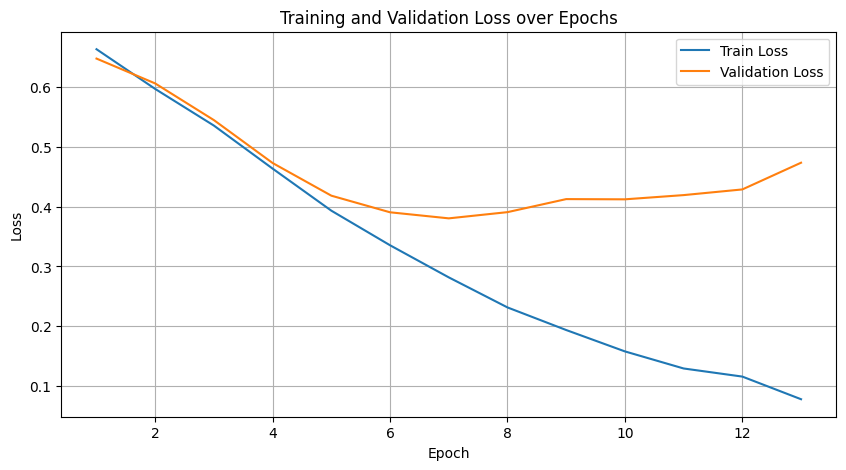

In [87]:
# Задаем количество эпох
epochs_range = range(1, len(train_loss_history) + 1)

# Визуализация ошибки по эпохам
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
# Прогнозирование на тестовых данных
model_ft.eval()
y_pred = []
y_score = []
with torch.no_grad():
    for inputs, labels in dataloaders_dict['test']:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        probabilities = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probabilities.cpu().numpy())

y_score = np.array(y_score)

In [89]:
# Оценка результатов
print(classification_report(y_test_num, y_pred, target_names=le.classes_))

                 precision    recall  f1-score   support

   appendicitis       0.88      0.82      0.85        91
no appendicitis       0.77      0.85      0.81        65

       accuracy                           0.83       156
      macro avg       0.83      0.84      0.83       156
   weighted avg       0.84      0.83      0.83       156



In [90]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test_num, y_pred, y_score, name='Neural_Network')])

## Обобщение результатов

In [91]:
metrics.set_index('model', inplace=True)
# Сортировка по столбцу ROC_AUC
sorted_metrics = metrics.sort_values(by='ROC_AUC', ascending=False)
round(sorted_metrics, 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Catboost_Baseline,0.95513,0.98161,0.95714,0.94366,0.95035,0.15161
Log_Reg_Baseline,0.91026,0.96040,0.89041,0.91549,0.90278,0.29004
Neural_Network,0.83333,0.92426,0.77465,0.84615,0.80882,0.35912


**Вывод:** наиболее удачным оказался выбор Catboost. Нейросеть из-за недостаточного количества объектов для обучения показала неудовлетворительный результат.